# Float example

This notebook shows how you can mimic the behavior of Argo floats and of an Isopycnal following float in OceanParcels.  The MUST MRV floats use a combination of these two float behaviors, with a depth-stepped profile from surface to 1000 followed by an isopycnal following phase followed by another profile to 1000 and then back to the surface to repeat the cycle.

In [9]:
# Define the new Kernel that mimics RW
def VerticalMovement(particle, fieldset, time):
    
    # set particle salinity at new depth for output
    particle.salt =  fieldset.salt[time, particle.depth, particle.lat, particle.lon]
    particle.temp = fieldset.temp[time, particle.depth, particle.lat, particle.lon]

    # can code vertical diffusivity here with random walk
    # ocean parcels has some random walk functions as well
    # have particle.dt for time step, particle.depth for depth
    
    # for now, lock to depth (surface)
    particle.depth = 0

Run OceanParcels with the Custom HabKernal.  Thus horizontal advection (and updated position) will be handled by OceanParcels and Vertical Position and interpolation of hydrography by the VerticalMovement routine. 

In [10]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable, plotTrajectoriesFile
from datetime import timedelta, datetime
import numpy as np
import os


# Load the HYCOM Analysis data in the Gulf of Maine
# The paths/datafiles should be read in from a control file
filenames = {'U': "./hycom_data/*.nc",
             'V': "./hycom_data/*.nc",
             'salt': "./hycom_data/*.nc",
             'temp': "./hycom_data/*.nc"}
variables = {'U': 'water_u',
             'V': 'water_v',
             'salt': 'salinity',
             'temp': 'water_temp'}
dimensions = {'lat': 'lat', 'lon': 'lon', 'depth' : 'depth' , 'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)#,allow_time_extrapolation = True)
fieldset.mindepth = fieldset.U.depth[0]  # uppermost layer in the hydrodynamic data

# print the domain boundaries to the screen
print("domain boundaries")
print(fieldset.U.lon[0],fieldset.U.lon[-1],fieldset.U.lat[0],fieldset.U.lat[-1])


# Define a new Particle type including extra Variables
#class ArgoParticle(JITParticle):
#    # Phase of cycle: init_descend=0, drift=1, profile_descend=2, profile_ascend=3, transmit=4
#    cycle_phase = Variable('cycle_phase', dtype=np.int32, initial=0.)
#    cycle_age = Variable('cycle_age', dtype=np.float32, initial=0.)
#    drift_age = Variable('drift_age', dtype=np.float32, initial=0.)
#    S = Variable('S', dtype=np.float32, initial=np.nan)  # store salinity
    
# Define a new Particle type including extra Variables
class HabParticle(JITParticle):
    # Phase of cycle: init_descend=0, drift=1, profile_descend=2, profile_ascend=3, transmit=4
    salt = Variable('salt', dtype=np.float32, initial=np.nan)  # store salinity
    temp = Variable('temp', dtype=np.float32, initial=np.nan)  # store water temperature

# Initiate two Isopycnal Floats with staggered starts and different programmed drift densities initiated from 
# different depths and horizontal locations.  These variables here (lon, lat, time, float_density) should
# be read in from a control file.
pset = ParticleSet.from_list(fieldset=fieldset,
                            pclass=HabParticle,
                            lon=[-70,-70],
                            lat=[43.,43.],
                            depth=[0,0],
                            time=[datetime(2016, 1, 1),
                            datetime(2016,1,2,0,0,0)])


# combine Argo vertical movement kernel with built-in Advection kernel
kernels = VerticalMovement + pset.Kernel(AdvectionRK4)
#kernels = IsoPycnalVerticalMovement + pset.Kernel(AdvectionRK4)

# Create a ParticleFile object to store the output
# outputdt might be read in from a control file
output_file = pset.ParticleFile(name="float_output/isopycnal_float", outputdt=timedelta(minutes=30))

# Now execute the kernels for 30 days, saving data every 30 minutes
# dt and runtime might be read in from a control file
pset.execute(kernels, runtime=timedelta(days=2), dt=timedelta(minutes=1), output_file=output_file)

domain boundaries
-74.0 -39.04004 37.04 62.0


/home/lcabral4/miniconda3/envs/py3_parcels/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)
INFO: Compiled ArrayHabParticleVerticalMovementAdvectionRK4 ==> /tmp/parcels-1000/lib8012d6a030e178d0c15b6b6b226ae6f8_0.so
INFO: Temporary output files are stored in float_output/out-BMCKQKKV.
INFO: You can use "parcels_convert_npydir_to_netcdf float_output/out-BMCKQKKV" to convert these to a NetCDF file during the run.
100% (172800.0 of 172800.0) |############| Elapsed Time: 0:01:05 Time:  0:01:05


Now we can plot the trajectory of the Isopycnal float with some simple calls to netCDF4 and matplotlib

/home/lcabral4/miniconda3/envs/py3_parcels/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


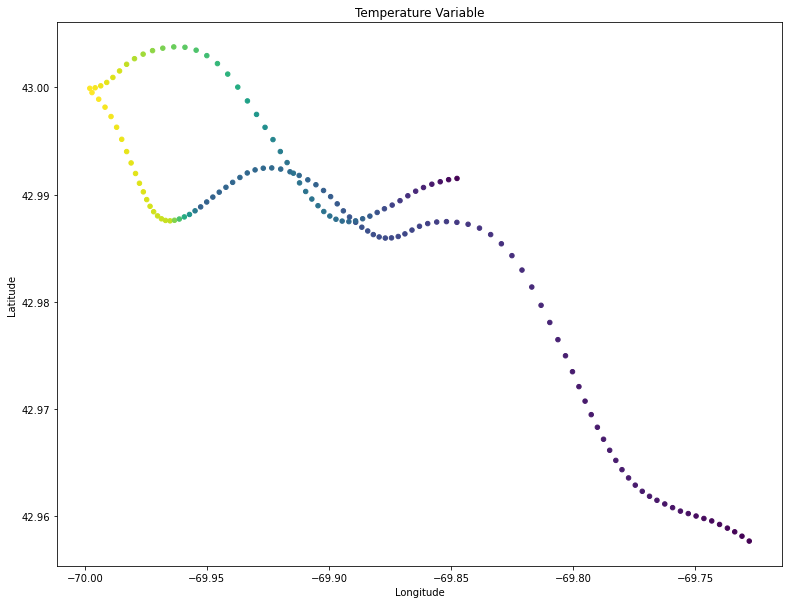

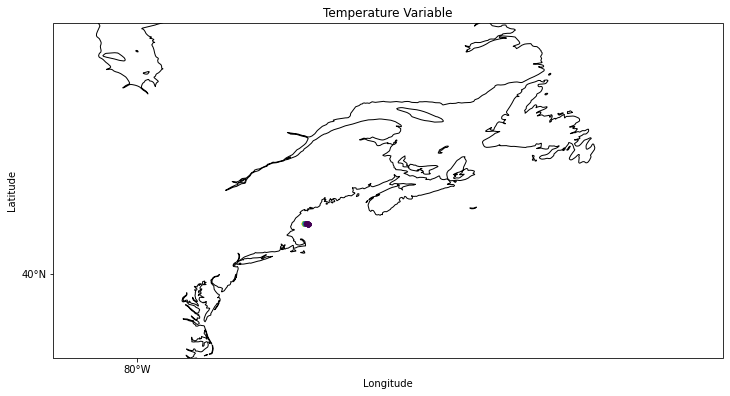

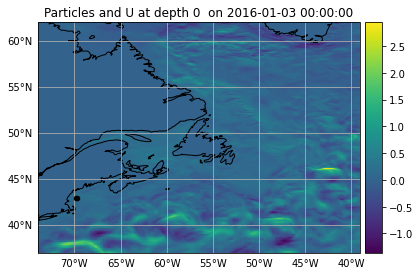

In [11]:
%matplotlib inline
#uncomment below for interactive plots (need ipympl)
####%matplotlib widget
import netCDF4
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
from mpl_toolkits.basemap import Basemap
from cartopy import config
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker 
from parcels import plotting
import matplotlib.pylab as pl

# using matplotlib basemap toolkit can add coastlines 
# install is picky about python version

output_file.export()  # export the trajectory data to a netcdf file

nc = netCDF4.Dataset("float_output/isopycnal_float.nc")

x = nc.variables["lon"][:].squeeze()
time = nc.variables["time"][:].squeeze()
y = nc.variables["lat"][:].squeeze()
z = nc.variables["z"][:].squeeze()
salt = nc.variables["salt"][:].squeeze()
temp = nc.variables["temp"][:].squeeze()
nc.close()


# plot
fig = plt.figure(figsize=(13,10))
ax = plt.axes()
#for p in range(x.shape[0]):
#    cb = ax.scatter(x[p,:], y[p,:], c=salt[p,:], s=20, marker="o")
#for p in range(x.shape[0]):
#    cb = ax.scatter(x[p,:], y[p,:], c=temp[p,:], s=20, marker = "o")

plt.title('Temperature Variable')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

for p in range(x.shape[0]):
    cb = ax.scatter(x[p,:], y[p,:], c=temp[p,:], s=20, marker = "o")
    
plt.show()

plt.figure(3, figsize = (12,15))
#m = Basemap(projection = 'mill',
#           llcrnrlat = 42,
#           llcrnrlon = -71,
#           urcrnrlat = 44,
#           urcrnrlon = -69,
#           resolution = 'l')
#m.drawcoastlines()
#m.drawcountries(linewidth = 2)
#m.drawstates(color = 'b')
#m.bluemarble()
#plt.title('Temperature Variable')
#ax.set_xlabel("Longitude")
#ax.set_ylabel("Latitude")

#for p in range(x.shape[0]):
#    cb = m.scatter(x[p,:], y[p,:], c=temp[p,:], s=20, marker = "o")

#for p in range(x.shape[0]):
#        cb = ax.scatter(x[p,:], y[p,:], marker = "o")

#m.drawparallels(np.arange(int(40.125),int(44.625),1),labels=[1,0,0,0])
#m.drawmeridians(np.arange(int(-71.875),int(-66.375),1),labels=[0,0,0,1])
#plt.legend()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-45, -85, 35, 55], ccrs.PlateCarree())
ax.coastlines()
#x = np.linspace(-65, -75)
#y = np.linspace(35, 45)
plt.title('Temperature Variable')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xticks(np.arange(-80,-65,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks(np.arange(40,50,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter) 
#lon, lat = np.meshgrid(x, y)
for p in range(x.shape[0]):
    cb = ax.scatter(x[p,:], y[p,:], c=temp[p,:], s=20, marker = "o")

pset.show(field=fieldset.U)



#pl.plot(x,y,'-o', markersize=40,markevery=x.size)
plt.show()

